# Engines to test:
## 1. Tesseract
## 2. PaddleOCR
## 3. EasyOCR

# Dataset

https://guillaumejaume.github.io/FUNSD/

In [1]:
import os
import json
import pandas as pd
import cv2
import matplotlib.pyplot as plt

annotations_folder = ''
images_folder = ''

data = []

for filename in os.listdir(annotations_folder):
    if filename.endswith('.json'):
        with open(os.path.join(annotations_folder, filename), 'r') as file:
            annotation_data = json.load(file)
            image_filename = filename.split('.')[0] + '.png'
            text = ""
            for item in annotation_data['form']:
                text += item['text'] + " "

            data.append({'filename': image_filename, 'text': text.strip()})

df = pd.DataFrame(data)

df.head()


,filename,text
0,71206427.png,ITEM: DATE: BRAND: SUMMARY OF PROJECT: Attache...
1,0001123541.png,DATE: DEPARTMENT: Type EQPR B&W QUALITY Implem...
2,83594639.png,Date: To: Company: From: 3 Lorillard 83594639 ...
3,92039708_9710.png,TO: FROM: SUBJECT: 92039708 SUBMISSION DATE MA...
4,0060029036.png,Brand(s) Company DATE SIGNATURE NAME Originato...


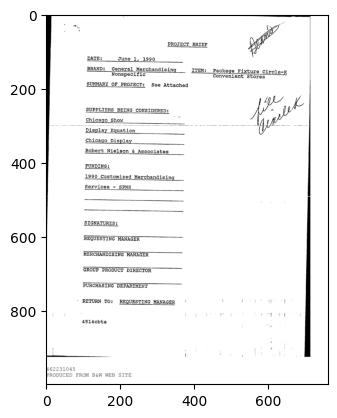

In [2]:
imgs_path = ""
img = cv2.imread(imgs_path + "71206427.png")
plt.imshow(img)

## Tesseract


In [3]:
!pip install pytesseract

In [4]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import time

In [5]:
def IoU(s1, s2):
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [6]:
IoUs_tess = []
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = set(pytesseract.image_to_string(img,lang = 'eng').replace('\n',' ').split(" "))
    gt = set(df[df['filename'] == row['filename']]['text'].values[0].split(" "))
    IoUs_tess.append(IoU(pt_output, gt))
fin = time.time()
n = len(df)
avg_tess_time = (fin - start)/n

In [24]:
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = pytesseract.image_to_string(img,lang = 'eng')
fin = time.time()
n = len(df)
avg_tess_time_no_prep = (fin - start)/n

In [7]:
import numpy as np
np.array(IoUs_tess).mean()

0.43582505097949276

In [8]:
(np.array(IoUs_tess) > 0.5).mean()

0.3165829145728643

## PaddleOCR

In [ ]:
!pip install paddleocr

In [10]:
from paddleocr import PaddleOCR

In [11]:
pocr_model = PaddleOCR(lang='en')


[2024/03/30 08:15:19] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, shape_info_filename=None, precision='fp32', gpu_mem=500, image_dir=None, det_algorithm='DB', det_model_dir='/Users/svitlanahovorova/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_box_type='quad', det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, det_fce_box_type='poly', rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/svitlanahovorova/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_shape='3, 48, 320', rec

In [12]:
def extract_text_from_output(output_list, easy=False):
    extracted_text = ""
    for item in output_list:
        if easy:
            text = item[1]
        else:
            text = item[1][0]
        extracted_text += text + " "
    return extracted_text.strip()

In [ ]:
IoUs_paddle = []
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = set(extract_text_from_output(pocr_model.ocr(img)).split(" "))
    gt = set(df[df['filename'] == row['filename']]['text'].values[0].split(" "))
    IoUs_paddle.append(IoU(pt_output, gt))
fin = time.time()

In [ ]:
start = time.time()
for _, row in df.iterrows():
    img = cv2.imread(imgs_path + row['filename'])
    pt_output = pocr_model.ocr(img)
fin = time.time()
avg_paddle_time_no_prep = (fin - start)/n

In [14]:
avg_paddle_time = (fin - start)/n

In [15]:
np.array(IoUs_paddle).mean()

0.5276247116984453

In [16]:
(np.array(IoUs_paddle) > 0.5).mean()

0.5829145728643216

## EasyOCR

In [ ]:
!pip install easyocr


In [18]:
import easyocr

In [19]:
reader = easyocr.Reader(['en', 'en'])

In [20]:
IoUs_easy = []
start = time.time()
for _, row in df.iterrows():
    output = reader.readtext(imgs_path  + row['filename'])
    pt_output = set(extract_text_from_output(output, easy=True).split(" "))
    gt = set(df[df['filename'] == row['filename']]['text'].values[0].split(" "))
    IoUs_easy.append(IoU(pt_output, gt))
fin = time.time()

In [28]:
start = time.time()
for _, row in df.iterrows():
    output = reader.readtext(imgs_path + row['filename'])
fin = time.time()
avg_easy_time_no_prep = (fin - start)/n

In [21]:
avg_easy_time = (fin - start)/n

In [22]:
np.array(IoUs_easy).mean()

0.3248959525402907

In [23]:
(np.array(IoUs_easy) > 0.5).mean()

0.12060301507537688

## Comparison table

In [29]:
comp_df = pd.DataFrame([{"engine": "Tesseract", "average IoU": np.array(IoUs_tess).mean(), "accuracy": (np.array(IoUs_tess) > 0.5).mean(), "average time": avg_tess_time, "average time no prep": avg_tess_time_no_prep},
                        {"engine": "PaddleOCR", "average IoU": np.array(IoUs_paddle).mean(), "accuracy": (np.array(IoUs_paddle) > 0.5).mean(), "average time": avg_paddle_time, "average time no prep": avg_paddle_time_no_prep},
                        {"engine": "EasyOCR", "average IoU": np.array(IoUs_easy).mean(), "accuracy": (np.array(IoUs_easy) > 0.5).mean(), "average time": avg_easy_time, "average time no prep": avg_easy_time_no_prep}])

In [30]:
comp_df

,engine,average IoU,accuracy,average time,average time no prep
0,Tesseract,0.435825,0.316583,0.492906,0.593123
1,PaddleOCR,0.527625,0.582915,4.393705,4.371691
2,EasyOCR,0.324896,0.120603,11.310212,10.680917
